# Siamese Neural Network With Pytorch

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import os
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image

print("Libraries imported - ready to use PyTorch", torch.__version__)

**Load Image Folder and Sub-folder of Image folder**

In [2]:
training_folder_name = 'D:/data/data'
img_size = (128,128)
classes = sorted(os.listdir(training_folder_name))
print(classes)

['with_mask', 'without_mask']


**Image Resize Function**

In [4]:
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    src_image.thumbnail(size, Image.ANTIALIAS)
    new_image = Image.new("RGB", size, bg_color)
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
    return new_image

**Convert Image Data Into Resized Data**

In [5]:
training_folder_name = 'D:/data/data'
#New location
train_folder = 'D:/data/Resized images'
size = (128,128)
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
       #Files in sub-folder through loop
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            file_path = os.path.join(root,sub_folder, file_name)
            image = Image.open(file_path)
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            resized_image.save(saveAs)

print('Done.')

Transforming images...
processing folder without_mask
processing folder with_mask


C:\Users\Micro Tec\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Done.


In [6]:
#Load Dataset
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    transformation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader
train_folder = 'D:/data/Resized images'
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read D:/data/Resized images


**Architechure Siamese Network**

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2)
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 32 * 32 * 24)
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)
device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=2, bias=True)
)


**Training Function**

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)          
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

**Test Function**

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return avg_loss

**Adam Optimizer For Adjust Weights**

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_criteria = nn.CrossEntropyLoss()
epoch_nums = []
training_loss = []
validation_loss = []
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 0.695249
	Training batch 2 Loss: 9.028457
	Training batch 3 Loss: 6.555150
	Training batch 4 Loss: 3.509977
	Training batch 5 Loss: 0.662957
	Training batch 6 Loss: 0.592475
	Training batch 7 Loss: 0.553054
	Training batch 8 Loss: 0.668545
	Training batch 9 Loss: 0.823594
	Training batch 10 Loss: 0.677738
	Training batch 11 Loss: 0.593815
	Training batch 12 Loss: 0.566230
	Training batch 13 Loss: 0.770614
	Training batch 14 Loss: 0.634316
	Training batch 15 Loss: 0.633518
	Training batch 16 Loss: 0.632004
	Training batch 17 Loss: 0.647053
	Training batch 18 Loss: 0.638848
	Training batch 19 Loss: 0.585842
	Training batch 20 Loss: 0.622177
	Training batch 21 Loss: 0.704014
	Training batch 22 Loss: 0.618593
	Training batch 23 Loss: 0.614187
	Training batch 24 Loss: 0.678860
	Training batch 25 Loss: 0.584787
	Training batch 26 Loss: 0.665603
	Training batch 27 Loss: 0.571882
	Training batch 28 Loss: 0.641835
	Training batch 29 Loss: 0.54976

**Graph Between Training And Validation**

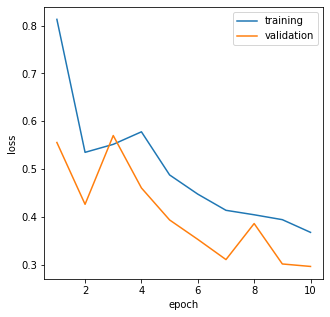

In [12]:
plt.figure(figsize=(5,5))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

**Evaluate Model**

Getting predictions from test set...


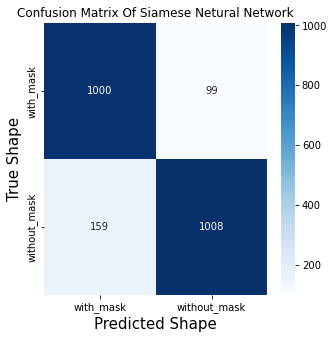

In [19]:
#labels and Predicitions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 
        
#Confusion Matrix Graph 
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 15)
plt.ylabel("True Shape", fontsize = 15)
plt.title("Confusion Matrix Of Siamese Netural Network")
plt.show()